<a href="https://colab.research.google.com/github/SiddTayi/RTD_Projs/blob/main/Stock_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM



In [2]:
#Load Data
company = 'AAPL'
start = dt.datetime(2012,1,12)
end = dt.datetime(2020,1,1)
data = web.DataReader(company, 'yahoo', start, end)
data = data.filter(['Close'])

In [3]:
data

,Close
Date,
2012-01-12,15.049643
2012-01-13,14.993214
2012-01-17,15.167857
2012-01-18,15.325357
2012-01-19,15.276786
...,...
2019-12-24,71.067497
2019-12-26,72.477501
2019-12-27,72.449997


In [4]:
#preparing data for NN
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.0185343 ],
       [0.01758536],
       [0.02052227],
       ...,
       [0.98381398],
       [0.99104513],
       [1.        ]])

In [5]:
scaled_data.shape

(2005, 1)

In [6]:
#look back days to predict
prediction_days = 60
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days: x, 0])
  y_train.append(scaled_data[x,0])



In [7]:
#train and test sets into numpy arr
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1945, 60)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1945, 60, 1)

In [9]:
#model building 

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Dense(1))



In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.fit(x_train, y_train, batch_size=5, epochs=5)

Epoch 1/5
389/389 [==============================] - 16s 42ms/step - loss: 9.7375e-04
Epoch 2/5
389/389 [==============================] - 16s 42ms/step - loss: 8.9501e-04
Epoch 3/5
389/389 [==============================] - 16s 42ms/step - loss: 9.1351e-04
Epoch 4/5
389/389 [==============================] - 16s 41ms/step - loss: 8.2172e-04
Epoch 5/5
389/389 [==============================] - 16s 41ms/step - loss: 9.0954e-04


In [28]:
# testing
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()
test_data = web.DataReader(company, 'yahoo', test_start, test_end)

In [29]:
actual_prices = test_data['Close'].values
actual_prices[:10]

array([75.08750153, 74.35749817, 74.94999695, 74.59750366, 75.79750061,
       77.40750122, 77.58249664, 79.23999786, 78.16999817, 77.83499908])

In [30]:
# training + testing data
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
total_dataset

Date
2012-01-12     15.049643
2012-01-13     14.993214
2012-01-17     15.167857
2012-01-18     15.325357
2012-01-19     15.276786
                 ...    
2021-06-24    133.410004
2021-06-25    133.110001
2021-06-28    134.779999
2021-06-29    136.330002
2021-06-30    136.914993
Name: Close, Length: 2382, dtype: float64

In [31]:
model_inputs = total_dataset[len(total_dataset)- len(test_data)- prediction_days :].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [32]:
#make predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [33]:
pred_price = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_price)

Text(0, 0.5, 'Share Price')

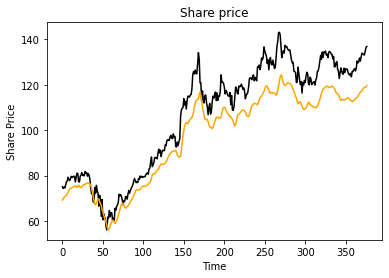

In [34]:
#plot

plt.plot(actual_prices,c='black')
plt.plot(pred_price,c='orange')
plt.title('Share price')
plt.xlabel('Time')
plt.ylabel('Share Price')


In [35]:
#predict next date
real_data = [model_inputs[len(model_inputs)+1 - prediction_days: len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))


In [36]:
pred = model.predict(real_data)
pred = scaler.inverse_transform(pred)
pred

array([[120.29115]], dtype=float32)